In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn. linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix,\
precision_recall_curve, f1_score,roc_curve, log_loss,SCORERS, fbeta_score, make_scorer

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('Churn_Eng_Data.csv', index_col = 0)

In [3]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,New_Balance,Exited
RowNumber,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,Zero,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,Mid,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,High,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,Zero,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,High,0


In [4]:
gender = pd.get_dummies(df['Gender'], drop_first=True)
geography = pd.get_dummies(df['Geography'], drop_first=True)
new_balance = pd.get_dummies(df['New_Balance'], drop_first=True)

In [5]:
X = df.iloc[:,2:13]
y = df.iloc[:,13]

In [6]:
X = pd.concat([X, gender, geography, new_balance], axis=1)
X = X.drop(['Gender', 'Geography', 'Balance', 'New_Balance'], axis = 1)

In [7]:
X.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain,Mid,Zero
RowNumber,,,,,,,,,,,,
1,619,42,2,1,1,1,101348.88,0,0,0,0,1
2,608,41,1,1,0,1,112542.58,0,0,1,1,0
3,502,42,8,3,1,0,113931.57,0,0,0,0,0
4,699,39,1,2,0,0,93826.63,0,0,0,0,1
5,850,43,2,1,1,1,79084.10,0,0,1,0,0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=711, stratify =y)

In [9]:
Scaler = StandardScaler()

X_trainsc = Scaler.fit_transform(X_train)
X_testsc = Scaler.transform(X_test)

## Baseline Dummy Classifier

In [413]:
dummy_class = DummyClassifier(strategy = 'constant', constant = 1)
dummy_class.fit(X_trainsc, y_train)

dummy_train_score =dummy_class.score(X_trainsc,y_train)
dummy_test_score = dummy_class.score(X_testsc, y_test)

print("Dummy Training Score: {:.2f}%".format(100*dummy_train_score))
print("Dummy Test Score: {:.2f}%".format(100*dummy_test_score))

Dummy Training Score: 20.38%
Dummy Test Score: 20.35%


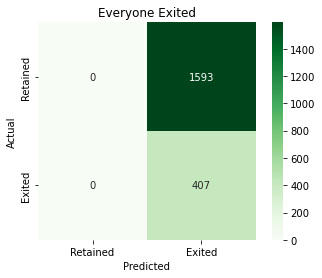

In [418]:
dummy_confusion = confusion_matrix(y_test, dummy_class.predict(X_testsc))
sns.heatmap(dummy_confusion, cmap="Greens", annot=True, square=True,fmt='g', 
            xticklabels=['Retained', 'Exited'], 
            yticklabels=['Retained', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Everyone Exited');
plt.savefig("Everyone_Exited.png")

In [420]:
dummy_class = DummyClassifier()
dummy_class.fit(X_trainsc, y_train)

dummy_train_score =dummy_class.score(X_trainsc,y_train)
dummy_test_score = dummy_class.score(X_testsc, y_test)

print("Dummy Training Score: {:.2f}%".format(100*dummy_train_score))
print("Dummy Test Score: {:.2f}%".format(100*dummy_test_score))

Dummy Training Score: 79.62%
Dummy Test Score: 79.65%


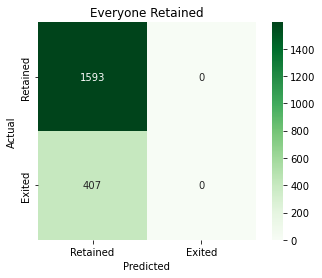

In [421]:
dummy_confusion = confusion_matrix(y_test, dummy_class.predict(X_testsc))
sns.heatmap(dummy_confusion, cmap="Greens", annot=True, square=True,fmt='g', 
            xticklabels=['Retained', 'Exited'], 
            yticklabels=['Retained', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Everyone Retained');
plt.savefig("Everyone_Retained.png")

In [12]:
fpr_dum, tpr_dum, thresholds_dum = roc_curve(y_test, dummy_class.predict_proba(X_testsc)[:,1])

## K Nearest Neighbors 

**- GridSearchCV**

In [13]:
knn = KNeighborsClassifier()

In [18]:
k_range = np.arange(1,25)
weight_options = ['uniform', 'distance']
fbeta_scorer = make_scorer(fbeta_score, beta=0.25)

In [19]:
param_grid_knn = dict(n_neighbors = k_range, weights=weight_options)
print(param_grid_knn)

{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]), 'weights': ['uniform', 'distance']}


In [20]:
gridcv_knn = GridSearchCV(knn, param_grid_knn, cv=10, scoring = fbeta_scorer)
gridcv_knn.fit(X_trainsc, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(fbeta_score, beta=0.25))

In [21]:
df_cv_knn = pd.DataFrame(gridcv_knn.cv_results_)
df_cv_knn.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006968,0.000441,0.029856,0.000584,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.409176,0.466717,0.496599,0.484911,0.488140,0.470280,0.504950,0.427315,0.510865,0.473891,0.473284,0.030968,46
1,0.007111,0.000711,0.018385,0.000298,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.409176,0.466717,0.496599,0.484911,0.488140,0.470280,0.504950,0.427315,0.510865,0.473891,0.473284,0.030968,46
2,0.006771,0.000291,0.035571,0.000320,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.506775,0.626062,0.612463,0.616744,0.570470,0.621779,0.577904,0.594536,0.632558,0.537313,0.589660,0.039485,41
3,0.006802,0.000276,0.024322,0.000784,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.409176,0.466717,0.496599,0.484911,0.488140,0.470280,0.504950,0.427315,0.510865,0.473891,0.473284,0.030968,46
4,0.006811,0.000302,0.040618,0.000788,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.514915,0.608696,0.555102,0.535203,0.517042,0.551351,0.566367,0.512427,0.520096,0.578559,0.545976,0.030392,44


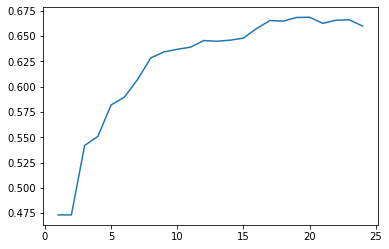

In [22]:
y_distance = df_cv_knn[df_cv_knn['param_weights'] == 'distance']['mean_test_score']
x = k_range
plt.plot(x, y_distance)

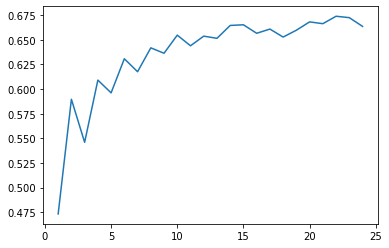

In [23]:
y_uniform = df_cv_knn[df_cv_knn['param_weights'] == 'uniform']['mean_test_score']
x = k_range
plt.plot(x, y_uniform)

In [24]:
#plt.plot(df['param_n_neighbors'])

In [25]:
print("Best params: ", gridcv_knn.best_params_)
print("Best estimator: ", gridcv_knn.best_estimator_)
print("Best score: ", gridcv_knn.best_score_)

Best params:  {'n_neighbors': 22, 'weights': 'uniform'}
Best estimator:  KNeighborsClassifier(n_neighbors=22)
Best score:  0.6739550835052677


In [26]:
knn = KNeighborsClassifier(n_neighbors = gridcv_knn.best_params_['n_neighbors'], weights = gridcv_knn.best_params_['weights'])
knn.fit(X_trainsc, y_train)

KNeighborsClassifier(n_neighbors=22)

In [27]:
knn_train_score = knn.score(X_trainsc, y_train)
knn_test_score = knn.score(X_testsc, y_test)
print("KNN Training Score: {:.2f}%".format(100*knn_train_score))
print("KNN Validation Score: {:.2f}%".format(100*knn_test_score))

KNN Training Score: 83.70%
KNN Validation Score: 82.45%


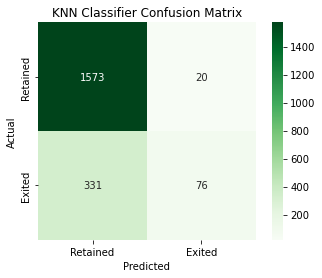

In [28]:
knn_confusion = confusion_matrix(y_test, knn.predict(X_testsc))
sns.heatmap(knn_confusion, cmap="Greens", annot=True, square=True,fmt='g', 
            xticklabels=['Retained', 'Exited'], 
            yticklabels=['Retained', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Classifier Confusion Matrix');
plt.savefig('KNN_Confusion.png')

In [29]:
knn_fbeta = fbeta_score(y_test, knn.predict(X_testsc), beta=0.25)
knn_precision = precision_score(y_test, knn.predict(X_testsc))
knn_recall = recall_score(y_test, knn.predict(X_testsc))
print("KNN F-Beta:{:.3f} KNN Precision:{:.3f} KNN Recall:{:.3f}".format(knn_fbeta, knn_precision, knn_recall))

KNN F-Beta:0.665 KNN Precision:0.792 KNN Recall:0.187


In [30]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn.predict_proba(X_testsc)[:,1])

## Logistic Regression

In [31]:
C_range = np.arange(.4,.7,0.01)
param_grid_lr = dict(C = C_range, penalty = ["l1","l2"],  solver = ['lbfgs', 'liblinear', 'sag', 'saga'])

In [32]:
gridcv_lr = GridSearchCV(LogisticRegression(max_iter=100), param_grid_lr, cv=10, scoring = 'accuracy')
gridcv_lr.fit(X_trainsc, y_train)

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [     nan 0.8125        nan 0.812625 0.812875 0.8125   0.812875 0.812875
      nan 0.8125        nan 0.8125   0.812875 0.8125   0.812875 0.81275
      nan 0.8125        nan 0.8125   0.81275  0.8125   0.81275  0.81275
      nan 0.8125        nan 0.8125   0.812625 0.8125   0.812875 0.812625
      nan 0.812625      nan 0.8125   0.812625 0.8125   0.812625 0.812625
      nan 0.812625      nan 0.8125   0.812625 0.8125   0.812625 0.812625
      nan 0.812625      nan 0.812625 0.812625 0.8125   0.812625 0.812625
      nan 0.812625      nan 0.812625 0.812625 0.8125   0.812625 0.812625
      nan 0.812625      nan 0.812625 0.812625 0.8125   0.812625 0.812625
      nan 0.812625      nan 0.812625 0.812625 0.8125   0.812625 0.812625
      nan 0.81275       nan 0.812625 0.812625 0.8125   0.812625 0.812625
      nan 0.81275       nan 0.812625

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61,
       0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga']},
             scoring='accuracy')

In [33]:
df_cv_lr = pd.DataFrame(gridcv_lr.cv_results_)
df_cv_lr.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000350,0.000045,0.000000,0.000000,0.4,l1,lbfgs,"{'C': 0.4, 'penalty': 'l1', 'solver': 'lbfgs'}",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240
1,0.009621,0.000568,0.000454,0.000350,0.4,l1,liblinear,"{'C': 0.4, 'penalty': 'l1', 'solver': 'libline...",0.81000,0.80750,...,0.82000,0.81500,0.80875,0.82375,0.80125,0.7975,0.8175,0.812500,0.008588,142
2,0.000436,0.000018,0.000000,0.000000,0.4,l1,sag,"{'C': 0.4, 'penalty': 'l1', 'solver': 'sag'}",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184
3,0.035428,0.001409,0.000323,0.000059,0.4,l1,saga,"{'C': 0.4, 'penalty': 'l1', 'solver': 'saga'}",0.81125,0.80750,...,0.82000,0.81500,0.80875,0.82375,0.80125,0.7975,0.8175,0.812625,0.008560,49
4,0.006214,0.000260,0.000324,0.000152,0.4,l2,lbfgs,"{'C': 0.4, 'penalty': 'l2', 'solver': 'lbfgs'}",0.81000,0.80875,...,0.82125,0.81625,0.80875,0.82375,0.80125,0.7975,0.8175,0.812875,0.008679,8


In [34]:
print("Best params: ", gridcv_lr.best_params_)
print("Best estimator: ", gridcv_lr.best_estimator_)
print("Best score: ", gridcv_lr.best_score_)

Best params:  {'C': 0.6400000000000002, 'penalty': 'l1', 'solver': 'liblinear'}
Best estimator:  LogisticRegression(C=0.6400000000000002, penalty='l1', solver='liblinear')
Best score:  0.8130000000000001


In [82]:
lr = LogisticRegression(C = gridcv_lr.best_params_['C'], max_iter = 100, multi_class='auto', 
                        penalty = gridcv_lr.best_params_['penalty'], solver= gridcv_lr.best_params_['solver'])
lr.fit(X_trainsc, y_train)
print("Logistic Training Score: {:.2f}%".format(100*lr.score(X_trainsc,y_train)))
print("Logistic Validation Score: {:.2f}%".format(100*lr.score(X_testsc,y_test)))

Logistic Training Score: 81.29%
Logistic Validation Score: 80.55%


In [83]:
col = pd.Series(X.columns)
coef_df = pd.DataFrame(lr.coef_.reshape(-1,1), columns=['Coefficients'])
coef_df = pd.concat([coef_df,col], axis=1)
coef_df = coef_df.rename({0:"Features"}, axis =1)
coef_df.sort_values('Coefficients', ascending = False)

,Coefficients,Features
1,0.751063,Age
8,0.336289,Germany
6,0.032484,EstimatedSalary
9,0.019223,Spain
4,-0.005712,HasCrCard
10,-0.026567,Mid
3,-0.026845,NumOfProducts
2,-0.044066,Tenure
0,-0.080105,CreditScore
11,-0.177206,Zero


In [84]:
confusion_matrix(y_test, lr.predict(X_testsc))

array([[1531,   62],
       [ 327,   80]])

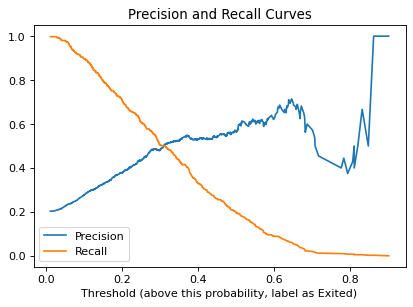

In [85]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lr.predict_proba(X_testsc)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='Precision')
plt.plot(threshold_curve, recall_curve[1:], label='Recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Exited)');
plt.title('Precision and Recall Curves');

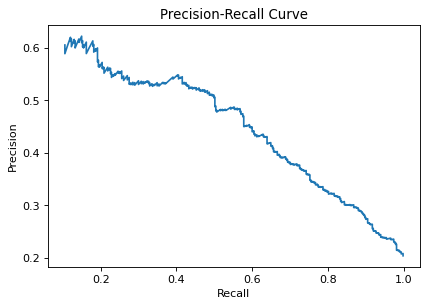

In [86]:
plt.figure(dpi=80)
plt.plot(recall_curve[10:1930], precision_curve[10:1930],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

**Equal Precision and Recall**

In [87]:
p_series = pd.Series(precision_curve[1:])
r_series = pd.Series(recall_curve[1:])
df_threshold = pd.DataFrame(threshold_curve, columns =['thresh'])

In [88]:
df_threshold = pd.concat([df_threshold, p_series, r_series], axis=1)
df_threshold = df_threshold.rename({0:'precis',1:'recall'}, axis='columns')

In [89]:
result = [z for x, y, z in zip(df_threshold['precis'], df_threshold['recall'], df_threshold['thresh']) if x == y]
result

[0.3090673163697586]

In [90]:
threshold = result[0]

y_predict = (lr.predict_proba(X_testsc)[:,1] > threshold)
print(f"Threshold of {threshold}:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Threshold of 0.3090673163697586:
Precision: 0.5012,   Recall: 0.5012


**Max Precision**

In [91]:
max_precis = df_threshold[df_threshold['precis'] == (df_threshold[df_threshold['thresh'].between(.55,.6)]['precis'].max())]
max_precis

,thresh,precis,recall
1938,0.592795,0.639344,0.095823


In [92]:
threshold = max_precis.iloc[0,0]

y_predict = (lr.predict_proba(X_testsc)[:,1] > threshold)
print(f"Threshold of {threshold}:")
print("F-Beta: {:6.4f}, Precision: {:6.4f}, Recall: {:6.4f}".format(fbeta_score(y_test, y_predict,beta=0.25),precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Threshold of 0.5927948682531761:
F-Beta: 0.4794, Precision: 0.6393, Recall: 0.0958


In [93]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_val) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_testsc)[:, 1] >= threshold)
    exited_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(exited_confusion, cmap="Greens", annot=True, square=True, fmt='d',
           xticklabels=['Retained', 'Exited'],
           yticklabels=['Retained', 'Exited']);
    plt.title('Logistic Regression Confusion Matrix');
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

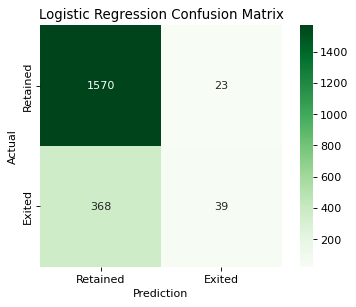

In [94]:
make_confusion_matrix(lr,max_precis.iloc[0,0])
plt.savefig('LR_Confusion.png')

In [95]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr.predict_proba(X_testsc)[:,1])

## Decision Tree

In [193]:
dc_range = np.arange(2,30)
param_grid_dc = dict(max_depth = dc_range, min_samples_split = range(2,15))
fbeta_scorer = make_scorer(fbeta_score, beta=0.25)

In [194]:
gridcv_dc = GridSearchCV(DecisionTreeClassifier(random_state=711), param_grid_dc, cv=10, scoring = 'precision')
gridcv_dc.fit(X_trainsc, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=711),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'min_samples_split': range(2, 15)},
             scoring='precision')

In [195]:
print("Best params: ", gridcv_dc.best_params_)
print("Best estimator: ", gridcv_dc.best_estimator_)
print("Best score: ", gridcv_dc.best_score_)

Best params:  {'max_depth': 3, 'min_samples_split': 2}
Best estimator:  DecisionTreeClassifier(max_depth=3, random_state=711)
Best score:  0.863554537417804


In [196]:
dc = DecisionTreeClassifier(max_depth = gridcv_dc.best_params_['max_depth'],
                            min_samples_split=gridcv_dc.best_params_['min_samples_split'], random_state = 711)
dc.fit(X_trainsc, y_train)
dc_train_score = dc.score(X_trainsc, y_train)
dc_test_score = dc.score(X_testsc,y_test)
print("DC Training Score: {:.2f}%".format(100*dc_train_score))
print("DC Test Score: {:.2f}%".format(100*dc_test_score))

DC Training Score: 84.25%
DC Test Score: 82.95%


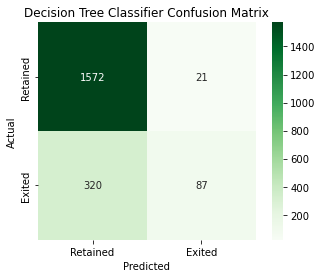

In [197]:
dc_confusion = confusion_matrix(y_test, dc.predict(X_testsc))
sns.heatmap(dc_confusion, cmap="Greens", annot=True, square=True,fmt='g', 
            xticklabels=['Retained', 'Exited'], 
            yticklabels=['Retained', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Classifier Confusion Matrix');
plt.savefig('DC_Confusion.png')

In [198]:
dc_fbeta = fbeta_score(y_test, dc.predict(X_testsc), beta=0.25)
dc_precision = precision_score(y_test, dc.predict(X_testsc))
dc_recall = recall_score(y_test, dc.predict(X_testsc))
print("DC F-Beta:{:.3f} DC Precision:{:.3f} DC Recall:{:.3f}".format(dc_fbeta, dc_precision, dc_recall))

DC F-Beta:0.693 DC Precision:0.806 DC Recall:0.214


In [186]:
fpr_dc, tpr_dc, thresholds_dc = roc_curve(y_test, dc.predict_proba(X_testsc)[:,1])

In [187]:
col = pd.Series(X.columns)
coef_df = pd.DataFrame(dc.feature_importances_.reshape(-1,1), columns=['Coefficients'])
coef_df = pd.concat([coef_df,col], axis=1)
coef_df = coef_df.rename({0:"Features"}, axis =1)
coef_df.sort_values('Coefficients', ascending = False)

,Coefficients,Features
1,0.514437,Age
3,0.294078,NumOfProducts
5,0.176170,IsActiveMember
11,0.015315,Zero
0,0.000000,CreditScore
2,0.000000,Tenure
4,0.000000,HasCrCard
6,0.000000,EstimatedSalary
7,0.000000,Male
8,0.000000,Germany


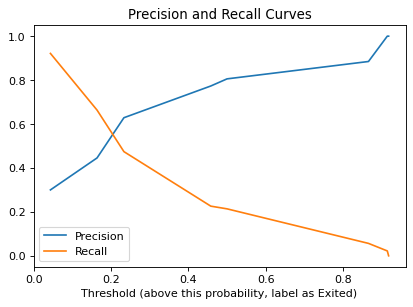

In [188]:
precision_curve_dc, recall_curve_dc, threshold_curve_dc = precision_recall_curve(y_test, dc.predict_proba(X_testsc)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve_dc, precision_curve_dc[1:],label='Precision')
plt.plot(threshold_curve_dc, recall_curve_dc[1:], label='Recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Exited)');
plt.title('Precision and Recall Curves');

## Random Forest

In [57]:
rf_range = np.arange(1,40)
md_range = np.arange(2,15)
param_grid_rf = dict(n_estimators = rf_range, max_depth=md_range)
fbeta_scorer = make_scorer(fbeta_score, beta=0.25)

In [58]:
gridcv_rf = GridSearchCV(RandomForestClassifier(random_state=711), param_grid_rf, cv=5, scoring = fbeta_scorer)
gridcv_rf.fit(X_trainsc, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=711),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])},
             scoring=make_scorer(fbeta_score, beta=0.25))

In [59]:
print("Best params: ", gridcv_rf.best_params_)
print("Best estimator: ", gridcv_rf.best_estimator_)
print("Best score: ", gridcv_rf.best_score_)

Best params:  {'max_depth': 5, 'n_estimators': 28}
Best estimator:  RandomForestClassifier(max_depth=5, n_estimators=28, random_state=711)
Best score:  0.8012472650759366


In [60]:
rf = RandomForestClassifier(n_estimators=gridcv_rf.best_params_['n_estimators'],max_depth =gridcv_rf.best_params_['max_depth'], random_state=711)
rf.fit(X_trainsc, y_train)

rf_train_score = rf.score(X_trainsc, y_train)
rf_test_score = rf.score(X_testsc,y_test)
print("RF Training Score: {:.2f}%".format(100*rf_train_score))
print("RF Test Score: {:.2f}%".format(100*rf_test_score))

RF Training Score: 85.56%
RF Test Score: 83.70%


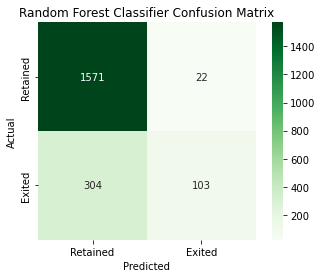

In [61]:
rf_confusion = confusion_matrix(y_test, rf.predict(X_testsc))
sns.heatmap(rf_confusion, cmap="Greens", annot=True, square=True,fmt='g', 
            xticklabels=['Retained', 'Exited'], 
            yticklabels=['Retained', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Classifier Confusion Matrix');
plt.savefig('RF_Confusion.png')

In [62]:
rf_fbeta = fbeta_score(y_test, rf.predict(X_testsc), beta=0.25)
rf_precision = precision_score(y_test, rf.predict(X_testsc))
rf_recall = recall_score(y_test, rf.predict(X_testsc))
print("RF F-Beta:{:.3f} RF Precision:{:.3f} RF Recall:{:.3f}".format(rf_fbeta, rf_precision, rf_recall))

RF F-Beta:0.727 RF Precision:0.824 RF Recall:0.253


In [63]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_testsc)[:,1])

In [64]:
col = pd.Series(X.columns)
coef_df = pd.DataFrame(rf.feature_importances_.reshape(-1,1), columns=['Coefficients'])
coef_df = pd.concat([coef_df,col], axis=1)
coef_df = coef_df.rename({0:"Features"}, axis =1)
coef_df.sort_values('Coefficients', ascending = False)

,Coefficients,Features
1,0.420250,Age
3,0.333974,NumOfProducts
5,0.082613,IsActiveMember
8,0.069595,Germany
0,0.024544,CreditScore
11,0.023639,Zero
7,0.016638,Male
6,0.013875,EstimatedSalary
2,0.005854,Tenure
9,0.003768,Spain


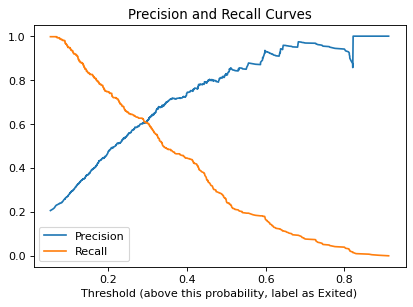

In [123]:
precision_curve_rf, recall_curve_rf, threshold_curve_rf = precision_recall_curve(y_test, rf.predict_proba(X_testsc)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve_rf, precision_curve_rf[1:],label='Precision')
plt.plot(threshold_curve_rf, recall_curve_rf[1:], label='Recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Exited)');
plt.title('Precision and Recall Curves');

## XGBOOST

In [242]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [65]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV

In [66]:
xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [67]:
xgb.fit(X_trainsc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [68]:
xgb_train_score = xgb.score(X_trainsc, y_train)
xgb_test_score = xgb.score(X_testsc,y_test)
print("RF Training Score: {:.2f}%".format(100*xgb_train_score))
print("RF Test Score: {:.2f}%".format(100*xgb_test_score))

RF Training Score: 94.39%
RF Test Score: 85.15%


/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [130]:
param_grid_xgb = {'n_estimators' : np.arange(50,250,50),
'subsample' : np.arange(0.4,1.2,0.2),
'max_depth' : np.arange(1,5),
'learning_rate' : np.arange(0.1,1,0.1),
'min_samples_split' : np.arange(1,6)}

# param_grid_xgb = dict(n_estimators = n_estimators, max_depth=max_depth)
fbeta_scorer = make_scorer(fbeta_score, beta=1)



In [131]:
params = {
    "max_depth": [2, 3, 4, 5, 6, 8, 10, 12, 15],
    "learning_rate": [0.5, 0.10, 0.15, 0.20, 0.25, 0.30],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}



In [164]:
random_cv = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='precision', n_jobs=1, cv=5, verbose=3)



In [165]:
random_cv.fit(X_trainsc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=2, min_child_weight=3;, score=0.730 total time=   0.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=2, min_child_weight=3;, score=0.790 total time=   0.1s
[CV 3/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=2, min_child_weight=3;, score=0.766 total time=   0.1s
[CV 4/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=2, min_child_weight=3;, score=0.761 total time=   0.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=2, min_child_weight=3;, score=0.752 total time=   0.1s
[CV 1/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5;, score=0.729 total time=   0.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=5;, score=0.777 total time=   0.1s
[CV 3/5] END colsample_bytr

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimato...
                                           reg_alpha=0, reg_lambda=1,
                                           scale_pos_weight=1, subs

In [169]:
print("Best params: ", random_cv.best_params_)
print("Best estimator: ", random_cv.best_estimator_)
print("Best score: ", random_cv.best_score_)

Best params:  {'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.3}
Best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='logloss',
              gamma=0.2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
Best score:  0.7603696086496158


In [170]:
xgb_class = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='logloss',
              gamma=0.2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=4, min_child_weight=1, 
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [171]:
xgb_class.fit(X_trainsc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='logloss',
              gamma=0.2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [172]:
xgb_train_score = xgb_class.score(X_trainsc, y_train)
xgb_test_score = xgb_class.score(X_testsc,y_test)
print("RF Training Score: {:.2f}%".format(100*xgb_train_score))
print("RF Test Score: {:.2f}%".format(100*xgb_test_score))

RF Training Score: 87.89%
RF Test Score: 85.50%


/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


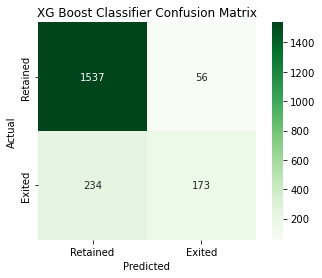

In [174]:
xgb_confusion = confusion_matrix(y_test, xgb_class.predict(X_testsc))
sns.heatmap(xgb_confusion, cmap="Greens", annot=True, square=True,fmt='g', 
            xticklabels=['Retained', 'Exited'], 
            yticklabels=['Retained', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XG Boost Classifier Confusion Matrix');
plt.savefig('XGB_Confusion.png')

In [175]:
xgb_fbeta = fbeta_score(y_test, xgb_class.predict(X_testsc), beta=1)
xgb_precision = precision_score(y_test, xgb_class.predict(X_testsc))
xgb_recall = recall_score(y_test, xgb_class.predict(X_testsc))
print("XGB F Beta:{:.3f} XGB Precision:{:.3f} XGB Recall:{:.3f}".format(xgb_fbeta,xgb_precision,xgb_recall))

XGB F Beta:0.544 XGB Precision:0.755 XGB Recall:0.425


/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [176]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_class.predict_proba(X_testsc)[:,1])

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


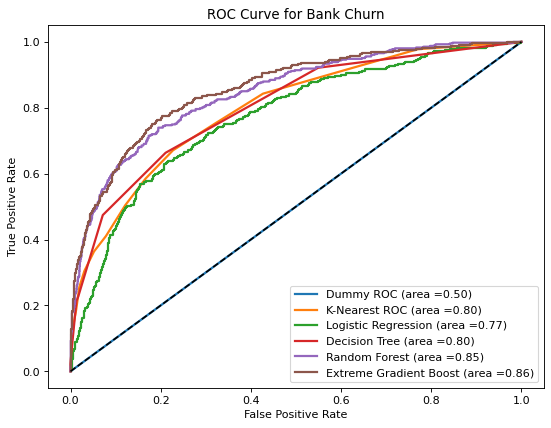

In [177]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(fpr_dum, tpr_dum,lw=2, label = "Dummy ROC (area ={:.2f})".format(roc_auc_score(y_test, dummy_class.predict_proba(X_testsc)[:,1])))
plt.plot(fpr_knn, tpr_knn,lw=2, label = "K-Nearest ROC (area ={:.2f})".format(roc_auc_score(y_test, knn.predict_proba(X_testsc)[:,1])))
plt.plot(fpr_lr, tpr_lr,lw=2, label = "Logistic Regression (area ={:.2f})".format(roc_auc_score(y_test, lr.predict_proba(X_testsc)[:,1])))
plt.plot(fpr_dc, tpr_dc,lw=2, label = "Decision Tree (area ={:.2f})".format(roc_auc_score(y_test, dc.predict_proba(X_testsc)[:,1])))
plt.plot(fpr_rf, tpr_rf,lw=2, label = "Random Forest (area ={:.2f})".format(roc_auc_score(y_test, rf.predict_proba(X_testsc)[:,1])))
plt.plot(fpr_xgb, tpr_xgb,lw=2, label = "Extreme Gradient Boost (area ={:.2f})".format(roc_auc_score(y_test, xgb_class.predict_proba(X_testsc)[:,1])))
plt.plot([0,1],[0,1],c='black',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Bank Churn');
plt.legend(loc='lower right')

In [178]:
print("Log-loss on dummy: {:6.4f}".format(log_loss(y_test, dummy_class.predict_proba(X_testsc))))
print("Log-loss on knn: {:6.4f}".format(log_loss(y_test, knn.predict_proba(X_testsc))))
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, lr.predict_proba(X_testsc))))
print("Log-loss on dc: {:6.4f}".format(log_loss(y_test, dc.predict_proba(X_testsc))))
print("Log-loss on rf: {:6.4f}".format(log_loss(y_test, rf.predict_proba(X_testsc))))
print("Log-loss on xgb: {:6.4f}".format(log_loss(y_test, xgb_class.predict_proba(X_testsc))))

Log-loss on dummy: 0.5052
Log-loss on knn: 0.5401
Log-loss on logit: 0.4280
Log-loss on dc: 0.3921
Log-loss on rf: 0.3748
Log-loss on xgb: 0.3455


/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [162]:
test_prob = xgb_class.predict_proba(X_testsc)[:,1]
len(test_prob[test_prob>0.5])

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


231

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


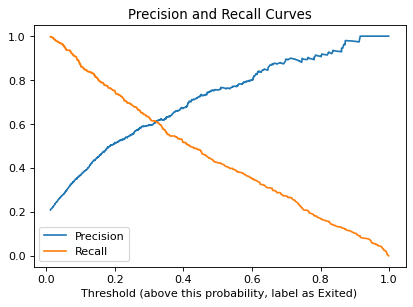

In [179]:
precision_curve_xgb, recall_curve_xgb, threshold_curve_xgb = precision_recall_curve(y_test, xgb_class.predict_proba(X_testsc)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve_xgb, precision_curve_xgb[1:],label='Precision')
plt.plot(threshold_curve_xgb, recall_curve_xgb[1:], label='Recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Exited)');
plt.title('Precision and Recall Curves');

In [299]:
col = pd.Series(X.columns)
coef_df = pd.DataFrame(xgb_class.feature_importances_.reshape(-1,1), columns=['Coefficients'])
coef_df = pd.concat([coef_df,col], axis=1)
coef_df = coef_df.rename({0:"Features"}, axis =1)
coef_df.sort_values('Coefficients', ascending = False)

,Coefficients,Features
3,0.331589,NumOfProducts
5,0.166128,IsActiveMember
1,0.140150,Age
8,0.120134,Germany
7,0.074238,Male
11,0.064423,Zero
0,0.023757,CreditScore
6,0.022050,EstimatedSalary
9,0.021833,Spain
10,0.013632,Mid


## Thresholding Analysis

In [363]:
X_test_res = X_test.reset_index()
X_test_res = X_test_res.merge(df[['Balance','CustomerId']], how='left', left_on="RowNumber", right_on="RowNumber")

In [364]:
xgb_pred = pd.Series(xgb_class.predict_proba(X_testsc)[:,1], name='Pred')
X_test_res = pd.concat([X_test_res,xgb_pred],axis=1, ignore_index = False)

In [366]:
X_test_res = X_test_res.merge(y_test, how='left', left_on="RowNumber", right_on="RowNumber")

In [517]:
X_res = X_test_res[X_test_res['Pred']>0.9].sort_values(['Pred','Balance'], ascending = False)

In [382]:
X_res

,RowNumber,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain,Mid,Zero,Balance,CustomerId,Pred,Exited
150,8,376,29,4,4,1,0,119346.88,0,1,0,1,0,115046.74,15656148,0.998629,1
74,2615,546,58,3,4,1,0,128881.87,0,1,0,1,0,106458.31,15640846,0.997863,1
407,6832,469,52,8,3,0,0,150093.32,0,1,0,0,0,139493.25,15696989,0.994660,1
1754,7534,630,51,0,3,0,0,88372.69,0,1,0,1,0,108449.23,15592773,0.994600,1
1164,1006,521,52,5,3,0,0,53793.10,1,1,0,1,0,116497.31,15701602,0.993649,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,2269,659,56,9,1,1,0,99504.03,0,0,0,0,0,123785.24,15777553,0.809396,1
1605,529,572,48,3,1,1,0,38411.79,0,1,0,0,0,152827.99,15653849,0.804545,1
1018,7207,753,47,1,1,1,0,197444.69,0,1,0,0,0,131160.85,15770995,0.803924,0
1807,536,608,59,1,1,1,0,70649.64,1,0,0,0,1,0.00,15776780,0.801417,1


In [449]:
bins = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
X_test_res['binned'] = pd.cut(X_test_res['Pred'], bins)
X_test_res

,RowNumber,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain,Mid,Zero,Balance,CustomerId,Pred,Exited,binned
0,4440,613,21,7,1,1,1,36560.51,0,0,0,1,0,105627.95,15696539,0.037715,0,"(0.0, 0.1]"
1,1372,611,43,8,1,1,0,114996.33,0,0,0,1,0,64897.75,15792722,0.449746,0,"(0.4, 0.5]"
2,5600,579,50,5,1,0,1,192146.63,0,1,0,1,0,117721.02,15635870,0.844946,1,"(0.8, 0.9]"
3,5313,712,48,8,2,1,0,183235.33,0,0,1,0,1,0.00,15726178,0.160832,0,"(0.1, 0.2]"
4,8755,776,43,4,2,0,1,162137.50,0,0,0,0,1,0.00,15619045,0.067825,0,"(0.0, 0.1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3008,602,33,5,1,0,1,180716.10,1,0,0,0,0,164704.38,15697997,0.057294,1,"(0.0, 0.1]"
1996,3731,683,38,3,1,0,0,15378.75,1,0,1,0,0,126152.84,15689152,0.126126,0,"(0.1, 0.2]"
1997,2955,538,33,5,2,1,0,126962.41,0,0,0,0,1,0.00,15775562,0.038199,0,"(0.0, 0.1]"
1998,2911,596,33,2,1,0,0,63142.12,1,0,0,0,0,139451.67,15746139,0.108537,0,"(0.1, 0.2]"


In [502]:
X_res_2 = X_test_res.groupby('binned',as_index=False)['Exited'].mean()
X_res_3 = X_test_res.groupby('binned', as_index=False)['Pred'].mean()
X_res_2.iloc[:,1]

0    0.051158
1    0.129380
2    0.308642
3    0.386555
4    0.445783
5    0.591837
6    0.589286
7    0.872340
8    0.823529
9    0.976744
Name: Exited, dtype: float64

In [523]:
X_res_3.iloc[:,1]

0    0.045174
1    0.141227
2    0.245670
3    0.348119
4    0.445194
5    0.552085
6    0.642945
7    0.748874
8    0.847393
9    0.958252
Name: Pred, dtype: float32

In [521]:
X_res

,RowNumber,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain,Mid,Zero,Balance,CustomerId,Pred,Exited,binned
150,8,376,29,4,4,1,0,119346.88,0,1,0,1,0,115046.74,15656148,0.998629,1,"(0.9, 1.0]"
74,2615,546,58,3,4,1,0,128881.87,0,1,0,1,0,106458.31,15640846,0.997863,1,"(0.9, 1.0]"
407,6832,469,52,8,3,0,0,150093.32,0,1,0,0,0,139493.25,15696989,0.994660,1,"(0.9, 1.0]"
1754,7534,630,51,0,3,0,0,88372.69,0,1,0,1,0,108449.23,15592773,0.994600,1,"(0.9, 1.0]"
1164,1006,521,52,5,3,0,0,53793.10,1,1,0,1,0,116497.31,15701602,0.993649,1,"(0.9, 1.0]"
1780,5116,533,49,1,3,1,0,69409.37,0,1,0,1,0,102286.60,15727317,0.993133,1,"(0.9, 1.0]"
1893,6256,547,55,4,3,1,0,16922.28,1,1,0,1,0,111362.76,15589017,0.992926,1,"(0.9, 1.0]"
1351,2510,655,50,10,4,1,0,179267.94,0,0,0,0,1,0.00,15689341,0.992536,1,"(0.9, 1.0]"
1465,8104,479,51,1,3,1,0,86128.21,1,1,0,1,0,107714.74,15740223,0.991080,1,"(0.9, 1.0]"
128,3205,547,50,3,3,0,1,177747.03,1,1,0,1,0,81290.02,15603942,0.990409,1,"(0.9, 1.0]"


In [518]:
X_res[['CustomerId','Age','Balance',"Tenure",'Pred','Exited']].head(30)

,CustomerId,Age,Balance,Tenure,Pred,Exited
150,15656148,29,115046.74,4,0.998629,1
74,15640846,58,106458.31,3,0.997863,1
407,15696989,52,139493.25,8,0.994660,1
1754,15592773,51,108449.23,0,0.994600,1
1164,15701602,52,116497.31,5,0.993649,1
1780,15727317,49,102286.60,1,0.993133,1
1893,15589017,55,111362.76,4,0.992926,1
1351,15689341,50,0.00,10,0.992536,1
1465,15740223,51,107714.74,1,0.991080,1
128,15603942,50,81290.02,3,0.990409,1


## Cost Modeling

In [396]:
new_pred_ones = np.ones(shape=(2000,))

conf = confusion_matrix(y_test, new_pred_ones)

total_cost = (conf[0,1] * 150) + (conf[1,1] * 150) + conf[1,0] * 750
total_savings = conf[1,1] * 750

net_gain = total_savings - total_cost
print(net_gain)

conf

5250


array([[   0, 1593],
       [   0,  407]])

In [407]:
new_pred_zeros = np.zeros(shape=(2000,))

conf = confusion_matrix(y_test, new_pred_zeros)

total_cost = (conf[0,1] * 150) + (conf[1,1] * 150) + conf[1,0] * 750
total_savings = conf[1,1] * 750

net_gain = total_savings - total_cost
print(net_gain)

conf


-305250


array([[1593,    0],
       [ 407,    0]])

In [385]:
dum_gains,dum_idx = model_cost(dummy_class)

Max net gain = 5250


In [386]:
knn_gains,knn_idx = model_cost(knn)

Max net gain = 55800


In [387]:
lr_gains,lr_idx = model_cost(lr)

Max net gain = 48450


In [388]:
dc_gains,dc_idx = model_cost(dc)

Max net gain = 69750


In [389]:
rf_gains,rf_idx = model_cost(rf)

Max net gain = 77700


In [441]:
xgb_gains,xgb_idx = model_cost(xgb_class)

Max net gain = 86850


In [434]:
res_list = list(zip(xgb_gains,xgb_idx))
res_df = pd.DataFrame(res_list, columns =['gains', 'idx'])

In [443]:
def make_confusion_matrix(model, threshold=0.07):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_val) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_testsc)[:, 1] >= threshold)
    exited_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(exited_confusion, cmap="Greens", annot=True, square=True, fmt='d',
           xticklabels=['Retained', 'Exited'],
           yticklabels=['Retained', 'Exited']);
    plt.title('XG Boost Confusion Matrix');
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

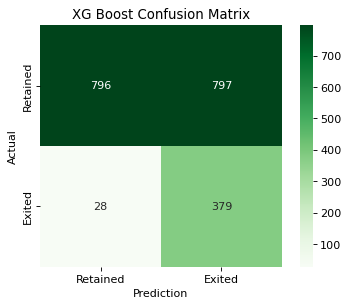

In [444]:
make_confusion_matrix(xgb_class)

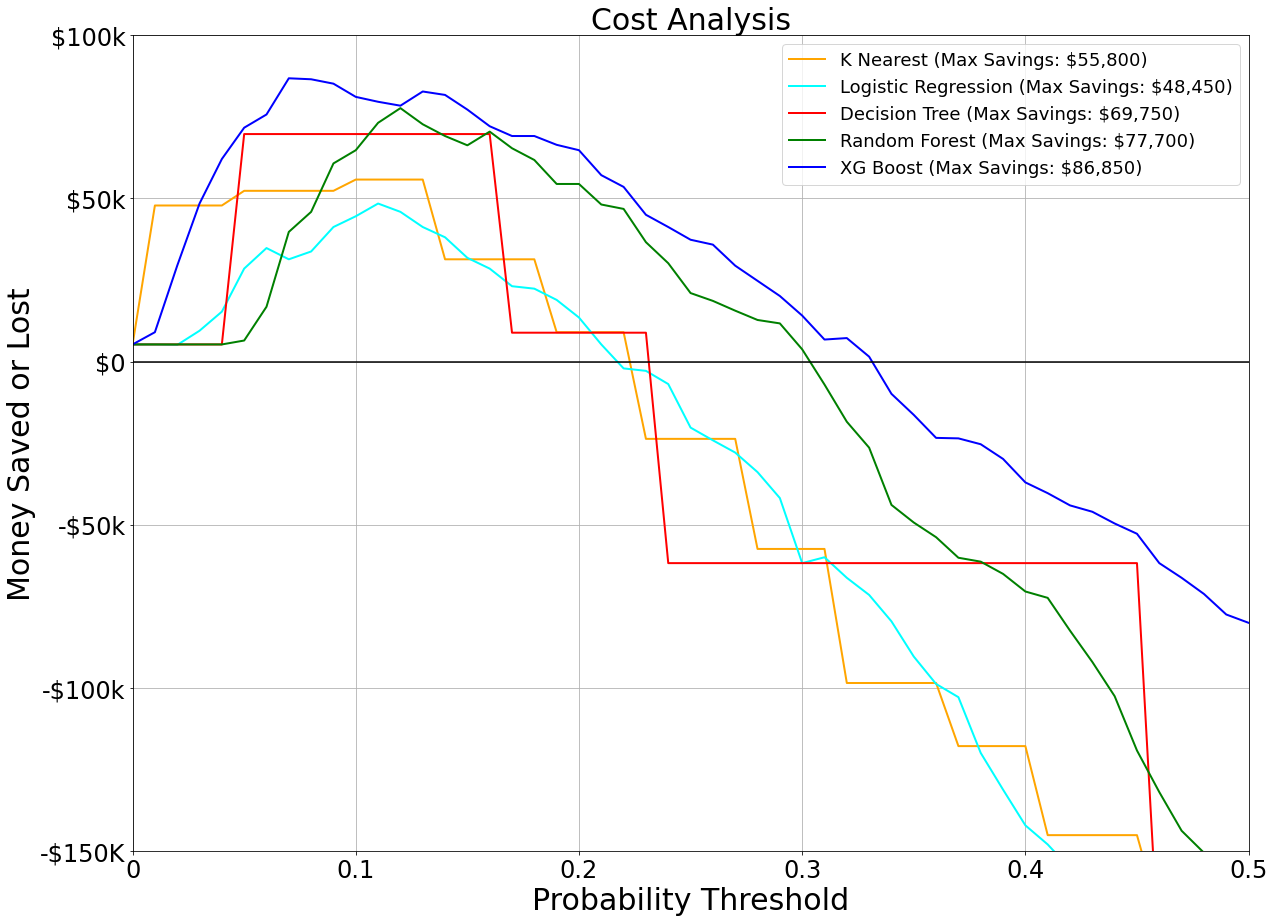

In [522]:
fig, ax = plt.subplots(figsize=(20, 15))
# plt.plot(dum_idx, dum_gains, label='Logistic Regression', color='purple', lw=2)
plt.plot(knn_idx, knn_gains, label='K Nearest (Max Savings: ${:,})'.format(max(knn_gains)), color='orange', lw=2)
plt.plot(lr_idx, lr_gains, label='Logistic Regression (Max Savings: ${:,})'.format(max(lr_gains)), color='cyan', lw=2)
plt.plot(dc_idx, dc_gains, label='Decision Tree (Max Savings: ${:,})'.format(max(dc_gains)), color='red', lw=2)
plt.plot(rf_idx, rf_gains, label='Random Forest (Max Savings: ${:,})'.format(max(rf_gains)), color='green', lw=2)
plt.plot(xgb_idx, xgb_gains, label='XG Boost (Max Savings: ${:,})'.format(max(xgb_gains)), color='blue', lw=2)
ax.axhline(y=0, color='black')
plt.grid()
ax.set_xbound(lower=0, upper=0.5)
ax.set_ybound(lower=-150000, upper=100000)
ax.set_yticklabels( ['-$150K','-$100k','-$50k', '$0', '$50k', '$100k'], fontsize=24)
ax.set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5'], fontsize=24)
plt.xlabel('Probability Threshold', fontsize=30)
plt.ylabel('Money Saved or Lost',fontsize=30)
plt.legend(fontsize=18)
plt.title('Cost Analysis',fontsize=30);
# plt.savefig('Cost_Analysis.png')